<a href="https://colab.research.google.com/github/robgon-art/GANscapes/blob/main/GANscapes_Image_Generation_with_CLIP_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GANscapes Using AI to Create New Impressionist Paintings**
How I trained StyleGAN2 ADA with 5,000 Impressionist landscape paintings in the public domain.

By Robert. A Gonsalves</br>
![alt text](https://raw.githubusercontent.com/robgon-art/GANscapes/main/images/GANscapes_small.jpg)

The source code and generated images are released under the [CC BY-NC-SA license](https://creativecommons.org/licenses/by-nc-sa/4.0/).</br>
![CC BY-NC-SA](https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png)


# **Initalize the System**
Hit the Run Cell (play) button to intialize the system.

In [ ]:
#@title
!git clone https://github.com/robgon-art/stylegan2-ada
%tensorflow_version 1.x
!gdown --id 1AHKufJ5o4dQFThFN0A-pJRRC2lzxEH2J
import sys
sys.path.insert(0, "stylegan2-ada")
import pickle
import PIL
import dnnlib
import dnnlib.tflib as tflib
import numpy as np
from PIL import ImageFont, ImageDraw
tflib.init_tf()
network_pkl="GANscapes.pkl"
print('Loading networks from "%s"...' %network_pkl)
with dnnlib.util.open_url(network_pkl) as fp:
  _G, _D, Gs = pickle.load(fp)

import torch
import html
print("Torch version:", torch.__version__)
!wget https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt -O model.pt
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

!wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz
!pip install ftfy

import os
from functools import lru_cache
import ftfy
import regex as re

@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()

def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text
import gzip
tokenizer = SimpleTokenizer()

def get_text_features(sentence):
  text_tokens = [tokenizer.encode("%s "%("picture of an impressionist " + sentence + " painting") + "<|endoftext|>")]
  text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
  for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)
  text_input = text_input.cuda()
  with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
  return text_features

def get_top_N_semantic_similarity(similarity_list, N, reverse, salt=0):
  salted_similarity = similarity_list + np.random.randn(len(similarity)) * salt
  results = zip(range(len(salted_similarity)), salted_similarity)
  results = sorted(results, key=lambda x: x[1], reverse=reverse)
  top_N_images = []
  scores = []
  indices = []
  for index, score in results[:N]:
    scores.append(score)
    top_N_images.append(pil_images[index].resize((int(1024*1.27),1024)))
    indices.append(index)
  return scores, top_N_images, indices

import random
starter_seed = random.randint(0, 31768)
initial_seeds = np.arange(starter_seed, starter_seed+1000, dtype="uint32").tolist()
truncation_psi = 0.75
w_avg = Gs.get_var('dlatent_avg')
Gs_syn_kwargs = {
    'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
    'randomize_noise': False,
    'minibatch_size': 4
}
initial_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in initial_seeds])
initial_w = Gs.components.mapping.run(initial_z, None)
initial_w = w_avg + (initial_w - w_avg) * truncation_psi
initial_images = Gs.components.synthesis.run(initial_w, **Gs_syn_kwargs)
pil_images = []
for img in initial_images:
  im = Image.fromarray(img)
  pil_images.append(im)
image_features = torch.empty((0, 512))
step = 1000

for start in range(0, len(pil_images), step):
  end = min(start + step, len(pil_images))
  images = [preprocess(im) for im in pil_images[start:end]]
  image_input = torch.tensor(np.stack(images)).cuda()
  image_input -= image_mean[:, None, None]
  image_input /= image_std[:, None, None]
  with torch.no_grad():
    image_feature_batch = model.encode_image(image_input).float()
  image_features = torch.cat([image_features, image_feature_batch.cpu()], dim=0)
  
image_features /= image_features.norm(dim=-1, keepdim=True)

# **Generate a Sample of Paintings and Show Thumbnails**
Hit the Run Cell button to generate thumbnail images using GANscapes.

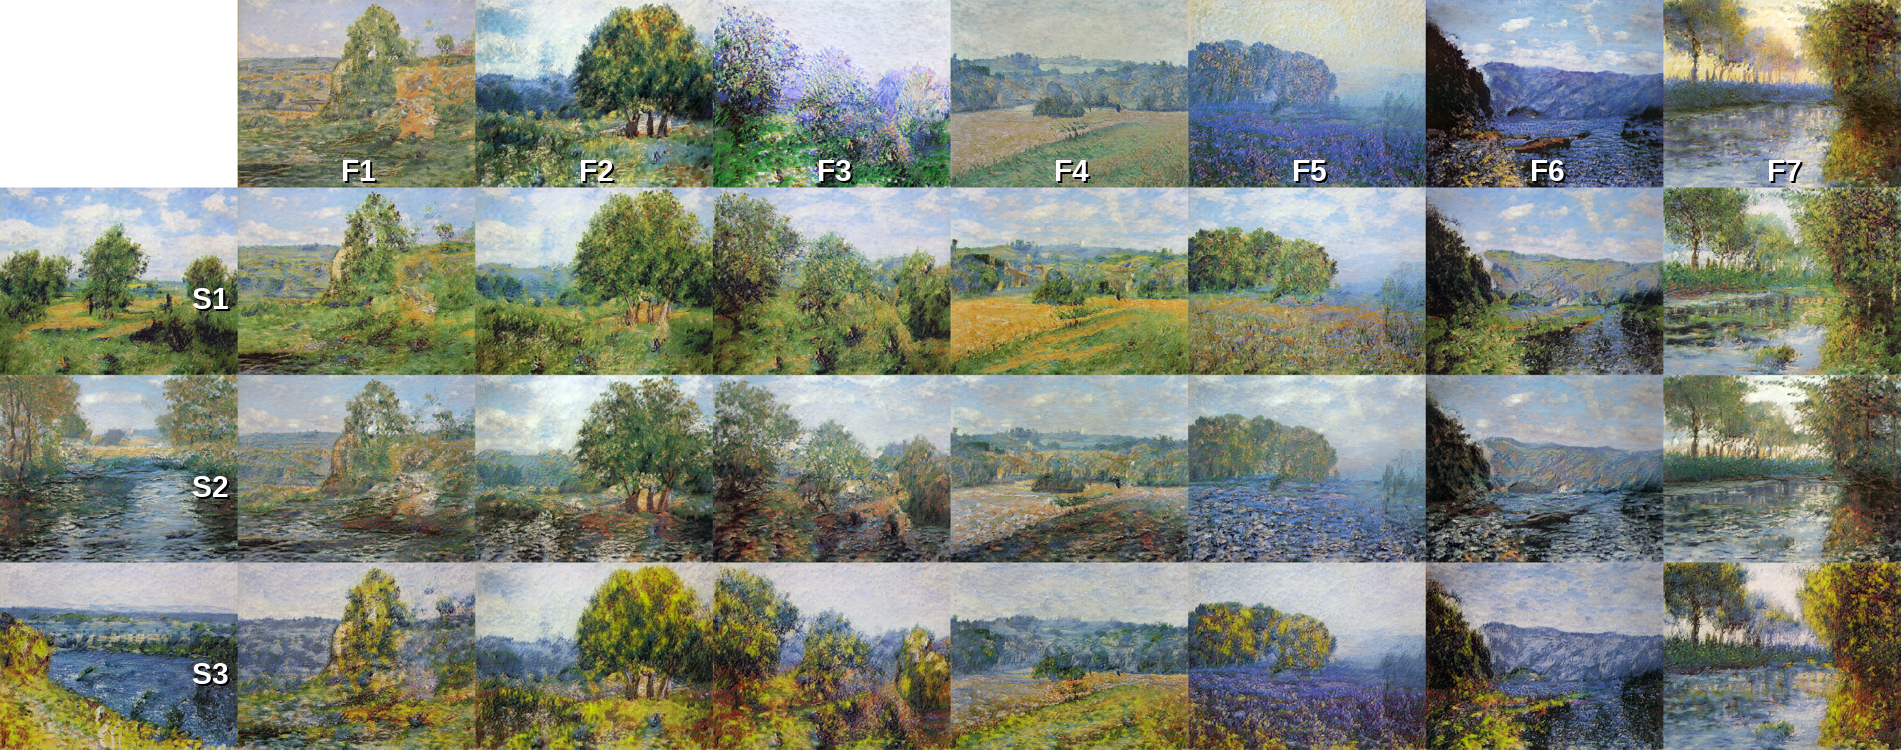

In [ ]:
semantic_search_phrase = "landscape" #@param ["landscape", "springtime field", "summer lake", "autumn woods", "winter mountains"] {allow-input: true}

text_features_extracted = get_text_features(semantic_search_phrase)
similarity = text_features_extracted.cpu().numpy() @ image_features.cpu().numpy().T
similarity = similarity[0]
scores, imgs, indices = get_top_N_semantic_similarity(similarity, N=10, reverse=True, salt=0.01)

row_seeds = []
for index in indices[-3:]:
  row_seeds.append(initial_seeds[index])
col_seeds = []
for index in indices[:7]:
  col_seeds.append(initial_seeds[index])

col_styles = test=np.arange(9, dtype="uint32").tolist()
truncation_psi = 0.75
outdir="out"
w_avg = Gs.get_var('dlatent_avg')
Gs_syn_kwargs = {
    'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
    'randomize_noise': False,
    'minibatch_size': 4
}

# Generate W vectors
all_seeds = list(set(row_seeds + col_seeds))
all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds])
all_w = Gs.components.mapping.run(all_z, None)
all_w = w_avg + (all_w - w_avg) * truncation_psi
w_dict = {seed: w for seed, w in zip(all_seeds, list(all_w))}

# Generate images
all_images = Gs.components.synthesis.run(all_w, **Gs_syn_kwargs)
image_dict = {(seed, seed): image for seed, image in zip(all_seeds, list(all_images))}

# Generate style-mixed images
for row_seed in row_seeds:
  for col_seed in col_seeds:
    w = w_dict[row_seed].copy()
    w[col_styles] = w_dict[col_seed][col_styles]
    image = Gs.components.synthesis.run(w[np.newaxis], **Gs_syn_kwargs)[0]
    image_dict[(row_seed, col_seed)] = image

# Create image grid
_N, _C, H, W = Gs.output_shape
canvas = PIL.Image.new('RGB', (W * (len(col_seeds) + 1), H * (len(row_seeds) + 1)), 'white')
for row_idx, row_seed in enumerate([None] + row_seeds):
  for col_idx, col_seed in enumerate([None] + col_seeds):
    if row_seed is None and col_seed is None:
      continue
    key = (row_seed, col_seed)
    if row_seed is None:
      key = (col_seed, col_seed)
    if col_seed is None:
      key = (row_seed, row_seed)
    canvas.paste(PIL.Image.fromarray(image_dict[key], 'RGB'), (W * col_idx, H * row_idx))

resized_canvas = canvas.resize((int(1500*1.2675), 750))
fnt = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', 30)
draw = ImageDraw.Draw(resized_canvas)
width, height = resized_canvas.size
for i in range(1, 8):
  x = round(i*width/8 + width/16)-15
  y = round(height/4.75)-5
  draw.text((x+2, y+2), 'F'+str(i), font=fnt, fill=(0,0,0))
  draw.text((x, y), 'F'+str(i), font=fnt, fill=(255,255,255))
for i in range(1, 4):
  x = round(width/8.75)-25
  y = round(i*height/4 + height/8)
  draw.text((x+2, y+2), 'S'+str(i), font=fnt, fill=(0,0,0))
  draw.text((x, y), 'S'+str(i), font=fnt, fill=(255,255,255))
resized_canvas

# **Choose a Painting**
Choose a landscape form with the slider, a landscape style with the menu, and hit the Run Cell button to see the full sized image.

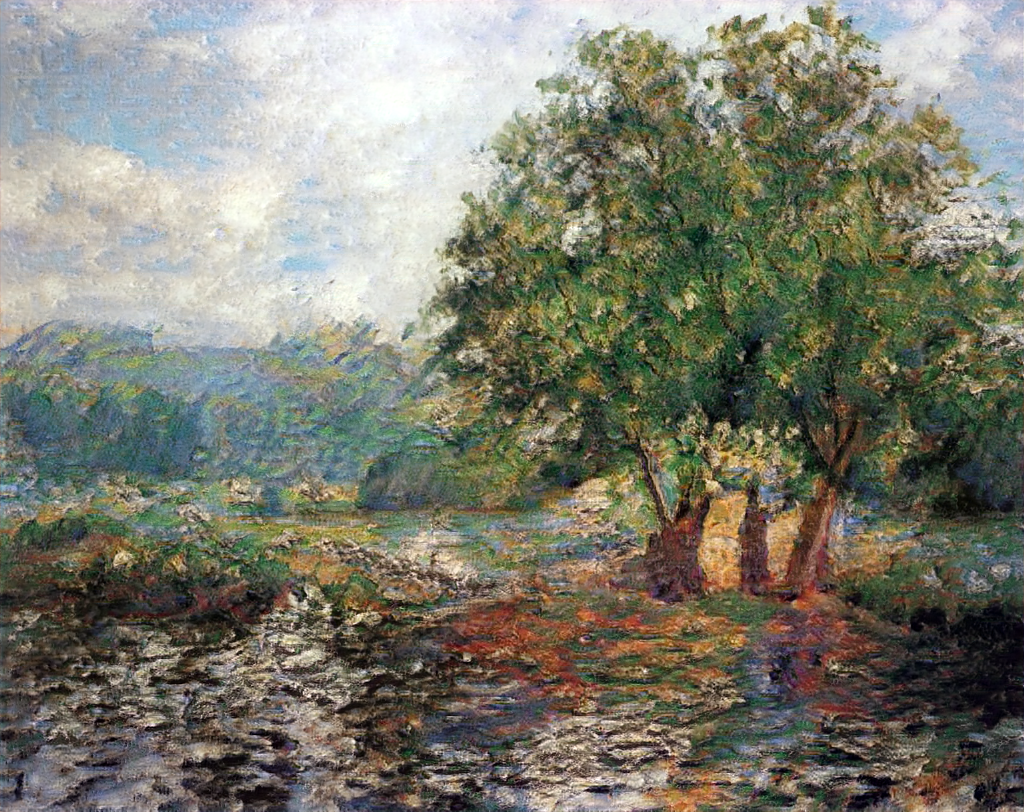

In [ ]:
Form = 2 #@param {type:"slider", min:0, max:7, step:1}
Style = '2' #@param ["Original", "1", "2", "3"]
form = Form
if Style is "Original":
  style = 0
else:
  style = int(Style)
rows = [None] + row_seeds
cols = [None] + col_seeds
row_seed = rows[style]
col_seed = cols[form]

if row_seed is None and col_seed is None:
  key = (rows[1], cols[1])
else:
  key = (row_seed, col_seed)
  if row_seed is None:
    key = (col_seed, col_seed)
  if col_seed is None:
    key = (row_seed, row_seed)

image_np = image_dict[key]

# convert the image to use floating point
image_contrast_enhanced_np = image_np.astype(np.float32)

# stretch the red channel by 0.1% at each end
r_min = np.percentile(image_np[:,:,0:1], 0.1)
r_max = np.percentile(image_np[:,:,0:1], 99.9)
image_contrast_enhanced_np[:,:,0:1] = (image_np[:,:,0:1]-r_min) * 255.0 / (r_max-r_min)

# stretch the green channel by 0.1% at each end
g_min = np.percentile(image_np[:,:,1:2], 0.1)
g_max = np.percentile(image_np[:,:,1:2], 99.9)
image_contrast_enhanced_np[:,:,1:2] = (image_np[:,:,1:2]-g_min) * 255.0 / (g_max-g_min)

# stretch the blue channel by 0.1% at each end
b_min = np.percentile(image_np[:,:,2:3], 0.1)
b_max = np.percentile(image_np[:,:,2:3], 99.9)
image_contrast_enhanced_np[:,:,2:3] = (image_np[:,:,2:3]-b_min) * 255.0 / (b_max-b_min)

# convert the image back to integer, after rounding and clipping
image_contrast_enhanced_np_int = np.clip(np.round(image_contrast_enhanced_np), 0, 255).astype(np.uint8)

# convert to the image to PIL and resize to fix the aspect ratio
image_contrast_enhanced=PIL.Image.fromarray(image_contrast_enhanced_np_int)
resized_enhanced_image=image_contrast_enhanced.resize((1024, int(1024/1.2718)))

resized_enhanced_image